# Трансферное обучение модели BERT для задачи интерактивного выявления уязвимостей веб-приложений

Здесь описывается процесс обучения и валидации модели машинного обучения, а также отсюда модель была опубликована на Hugging Face Hub.

Установка зависимостей:

In [1]:
!pip install transformers datasets huggingface_hub torch pandas scikit-learn matplotlib

Импортируем нужные библиотеки:

In [2]:
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

Для аппаратного ускорения обучения и валидации модели используется графический процессор (GPU). Определяем, доступен ли он:

In [3]:
if torch.cuda.is_available():
    print(f"GPU доступен: {torch.cuda.get_device_name(0)}")
else:
    print("GPU недоступен, используется CPU")

GPU доступен: Tesla T4


Для обучения используем GPU, если он доступен. Если нет - используем центральный процессор (CPU).

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Загружаем собранный датасет с Hugging Face Hub:

In [5]:
dataset = load_dataset("l1ghth4t/iast-python3-django-flask")

Отображаем первые записи обучающего и валидационного набора данных:

In [6]:
print(dataset["train"][0])
print(dataset["validation"][0])

{'text': '{\'context_id\': 490, \'vulnerable\': True, \'processing\': False, \'request\': {\'url\': \'http://www.martinez.com/main/app/taghome.htm\', \'method\': \'DELETE\', \'headers\': {\'HOST\': \'127.0.0.1:5000\', \'USER_AGENT\': \'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:134.0) Gecko/20100101 Firefox/134.0\', \'ACCEPT\': \'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8\', \'ACCEPT_LANGUAGE\': \'en-US,en;q=0.5\', \'ACCEPT_ENCODING\': \'gzip, deflate, br, zstd\', \'REFERER\': \'http://127.0.0.1:5000/guestbook\', \'CONNECTION\': \'keep-alive\', \'COOKIE\': \'csrftoken=7GgBqVlBL6WuGdfu3e6EBXep8N5vFiVm; grafana_session=54c841e9cb2f4956a7c791efd284d120; grafana_session_expiry=1735995560; user_id=2; session_token=b3c634c91e1711c794704a031918a34b; session=eyJjc3JmX3Rva2VuIjoiMzNkNDNlNjA2MDhiMjdjZjBiMGI1Yzk3NWU4MDExZjRjYWMxMzRhNyJ9.Z5GBRA.Q8r4qzslZbU-6Y0h-x9F551fn1A\', \'UPGRADE_INSECURE_REQUESTS\': \'1\', \'SEC_FETCH_DEST\': \'document\', \'SEC_FETCH_MODE\': \'navigate\

Извлекаем метки из датасета:

In [7]:
unique_labels = list(set(dataset["train"]["label"]))  # Собираем уникальные метки из тренировочного набора
unique_labels.sort()  # Сортируем для консистентности
label2id = {label: idx for idx, label in enumerate(unique_labels)}  # Создаём отображение строк -> индексы
id2label = {idx: label for label, idx in label2id.items()}  # Обратное отображение
label2id

{'CWE-16': 0,
 'CWE-352': 1,
 'CWE-400': 2,
 'CWE-502': 3,
 'CWE-639': 4,
 'CWE-77': 5,
 'CWE-79': 6,
 'CWE-89': 7,
 'CWE-918': 8,
 'Clean': 9}

Загружаем токенизатор модели BERT:

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Создаём функцию для преобразования записи в нужный формат. Токенизируем каждую часть контекста выполнения запроса (`request`, `control_flow`, `response`) и сохраняем метку.

In [9]:
import ast

def preprocess(example):
    json_example = ast.literal_eval(example['text'])
    # Обработка блока Request
    request_text = f"URL: {json_example['request']['url']}\n" \
                   f"Method: {json_example['request']['method']}\n" \
                   f"Headers: {json_example['request']['headers']}\n" \
                   f"Body: {json_example['request']['body']}"
    request_tokens = tokenizer(request_text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    # Обработка блока Control Flow
    control_flow_text = "\n".join([f"{k}: {v}" for k, v in json_example['control_flow'].items()])
    control_flow_tokens = tokenizer(control_flow_text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    # Обработка блока Response
    response_text = f"Status Code: {json_example['response']['status_code']}\n" \
                    f"Headers: {json_example['response']['headers']}"
    response_tokens = tokenizer(response_text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    return {
        "request_input_ids": request_tokens["input_ids"].squeeze(0),
        "request_attention_mask": request_tokens["attention_mask"].squeeze(0),
        "control_flow_input_ids": control_flow_tokens["input_ids"].squeeze(0),
        "control_flow_attention_mask": control_flow_tokens["attention_mask"].squeeze(0),
        "response_input_ids": response_tokens["input_ids"].squeeze(0),
        "response_attention_mask": response_tokens["attention_mask"].squeeze(0),
        "label": label2id[example["label"]]
    }

Преобразуем датасет с помощью функции `map`:

In [10]:
tokenized_dataset = dataset.map(preprocess, batched=False)
print(tokenized_dataset["train"][0])

{'text': '{\'context_id\': 490, \'vulnerable\': True, \'processing\': False, \'request\': {\'url\': \'http://www.martinez.com/main/app/taghome.htm\', \'method\': \'DELETE\', \'headers\': {\'HOST\': \'127.0.0.1:5000\', \'USER_AGENT\': \'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:134.0) Gecko/20100101 Firefox/134.0\', \'ACCEPT\': \'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8\', \'ACCEPT_LANGUAGE\': \'en-US,en;q=0.5\', \'ACCEPT_ENCODING\': \'gzip, deflate, br, zstd\', \'REFERER\': \'http://127.0.0.1:5000/guestbook\', \'CONNECTION\': \'keep-alive\', \'COOKIE\': \'csrftoken=7GgBqVlBL6WuGdfu3e6EBXep8N5vFiVm; grafana_session=54c841e9cb2f4956a7c791efd284d120; grafana_session_expiry=1735995560; user_id=2; session_token=b3c634c91e1711c794704a031918a34b; session=eyJjc3JmX3Rva2VuIjoiMzNkNDNlNjA2MDhiMjdjZjBiMGI1Yzk3NWU4MDExZjRjYWMxMzRhNyJ9.Z5GBRA.Q8r4qzslZbU-6Y0h-x9F551fn1A\', \'UPGRADE_INSECURE_REQUESTS\': \'1\', \'SEC_FETCH_DEST\': \'document\', \'SEC_FETCH_MODE\': \'navigate\

Создаем функцию для преобразования данных в тензоры:

In [11]:
def collate_fn(batch):
    def to_tensor(item_list):
        if isinstance(item_list[0], torch.Tensor):
            return torch.stack(item_list)
        return torch.tensor(item_list)

    return {
        "request_input_ids": to_tensor([item["request_input_ids"] for item in batch]),
        "request_attention_mask": to_tensor([item["request_attention_mask"] for item in batch]),
        "control_flow_input_ids": to_tensor([item["control_flow_input_ids"] for item in batch]),
        "control_flow_attention_mask": to_tensor([item["control_flow_attention_mask"] for item in batch]),
        "response_input_ids": to_tensor([item["response_input_ids"] for item in batch]),
        "response_attention_mask": to_tensor([item["response_attention_mask"] for item in batch]),
        "label": to_tensor([item["label"] for item in batch])
    }

Создаём DataLoader с collate_fn:

In [12]:
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=16, collate_fn=collate_fn)

Создаем модифицированную архитектуру модели машинного обучения на базе BERT. Модель BERT используется для извлечения признаков из запроса, ответа и потока управления. Далее эти признаки объединяются через линейный слой для классификации уязвимостей. Так как длина данных о запросе, ответе или потоке управления может превышать лимит модели BERT (512 токенов), они обрабатываются моделью BERT по отдельности.

In [13]:
import torch
import torch.nn as nn
from transformers import BertModel

class IAST_BERT(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", num_classes=10, dropout_prob=0.5):
        super(IAST_BERT, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc_request = nn.Linear(768, 256)
        self.fc_control_flow = nn.Linear(768, 256)
        self.fc_response = nn.Linear(768, 256)
        self.fc_final = nn.Linear(256 * 3, num_classes)

    def forward(self, request_input, request_mask, control_flow_input, control_flow_mask, response_input, response_mask):
        # Request
        request_outputs = self.bert(input_ids=request_input, attention_mask=request_mask)
        request_features = torch.mean(request_outputs.last_hidden_state, dim=1)  # Среднее по последнему слою
        request_features = self.fc_request(self.dropout(request_features))

        # Control Flow
        control_flow_outputs = self.bert(input_ids=control_flow_input, attention_mask=control_flow_mask)
        control_flow_features = torch.mean(control_flow_outputs.last_hidden_state, dim=1)
        control_flow_features = self.fc_control_flow(self.dropout(control_flow_features))

        # Response
        response_outputs = self.bert(input_ids=response_input, attention_mask=response_mask)
        response_features = torch.mean(response_outputs.last_hidden_state, dim=1)
        response_features = self.fc_response(self.dropout(response_features))

        # Объединение
        combined_features = torch.cat([request_features, control_flow_features, response_features], dim=1)
        logits = self.fc_final(self.dropout(combined_features))

        return logits

## Обучение модели

Создается экземпляр модели `IAST_BERT`, который затем переносится на выбранное устройство. Далее настраивается оптимизатор `AdamW` для обновления параметров модели, и выбирается функция потерь `CrossEntropyLoss` для оценки качества классификации:

In [14]:
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = list(id2label.values())
class_weights = compute_class_weight("balanced", classes=np.unique(class_labels), y=class_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = IAST_BERT()
model = model.to(device)

# Заморозка BERT
for param in model.bert.parameters():
    param.requires_grad = False

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

/root/notebook/venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Отображаем иерархию модулей модели:

In [15]:
model

IAST_BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

Цикл обучения модели:

In [16]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        # Перемещаем данные на GPU
        inputs = {
            "request_input": batch["request_input_ids"].to(device),
            "request_mask": batch["request_attention_mask"].to(device),
            "control_flow_input": batch["control_flow_input_ids"].to(device),
            "control_flow_mask": batch["control_flow_attention_mask"].to(device),
            "response_input": batch["response_input_ids"].to(device),
            "response_mask": batch["response_attention_mask"].to(device),
        }
        labels = batch["label"].to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        logits = model(**inputs)

        # Вычисляем loss
        loss = criterion(logits, labels)

        # Обратный проход
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

Epoch 1, Loss: 0.6308402483882871
Epoch 2, Loss: 0.2294668198557264
Epoch 3, Loss: 0.11586985204140525


## Валидация модели

Оцениваем обученную модель на валидационном датасете. Модель переводится в режим оценки (`model.eval()`), затем данные проходят через модель без вычисления градиентов (`torch.no_grad()`). Для каждого батча вычисляются логиты и предсказания, после чего они сохраняются вместе с истинными метками. В конце выводится сообщение о завершении процесса оценки.

In [17]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import torch
import numpy as np
from tqdm.notebook import tqdm

# Перевод модели в режим оценки
model.eval()

# Переменные для хранения меток
all_labels = []
all_predictions = []

# Оценка на валидационном датасете
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        # Перенос данных на устройство (CPU/GPU)
        inputs = {
            "request_input": batch["request_input_ids"].to(device),
            "request_mask": batch["request_attention_mask"].to(device),
            "control_flow_input": batch["control_flow_input_ids"].to(device),
            "control_flow_mask": batch["control_flow_attention_mask"].to(device),
            "response_input": batch["response_input_ids"].to(device),
            "response_mask": batch["response_attention_mask"].to(device),
        }
        labels = batch["label"].to(device)

        # Прогон данных через модель
        logits = model(**inputs)
        predictions = torch.argmax(logits, dim=1)

        # Сохранение истинных меток и предсказаний
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

print("Оценка завершена.")

Evaluating:   0%|          | 0/1896 [00:00<?, ?it/s]

Оценка завершена.


Рассчитываем метрики точности (`Accuracy`), полноты (`Precision`), чувствительности (`Recall`) и гармонизированный показатель F1 (`F1-Score`):

In [18]:
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


Формируем отчет о классификации:

In [19]:
class_report = classification_report(all_labels, all_predictions, target_names=unique_labels)
print("Отчёт о классификации:")
print(class_report)

Отчёт о классификации:
              precision    recall  f1-score   support

      CWE-16       1.00      1.00      1.00       384
     CWE-352       1.00      1.00      1.00       192
     CWE-400       1.00      1.00      1.00      6528
     CWE-502       1.00      1.00      1.00      1344
     CWE-639       1.00      1.00      1.00      1152
      CWE-77       1.00      1.00      1.00       768
      CWE-79       1.00      1.00      1.00      3456
      CWE-89       1.00      1.00      1.00      1920
     CWE-918       1.00      1.00      1.00       768
       Clean       1.00      1.00      1.00     13824

    accuracy                           1.00     30336
   macro avg       1.00      1.00      1.00     30336
weighted avg       1.00      1.00      1.00     30336



Строим матрицу ошибок, используя результаты предсказаний и истинные метки. Матрица ошибок нормализована, чтобы значения были в пределах от 0 до 1. Затем отображаем её с помощью библиотеки Matplotlib:

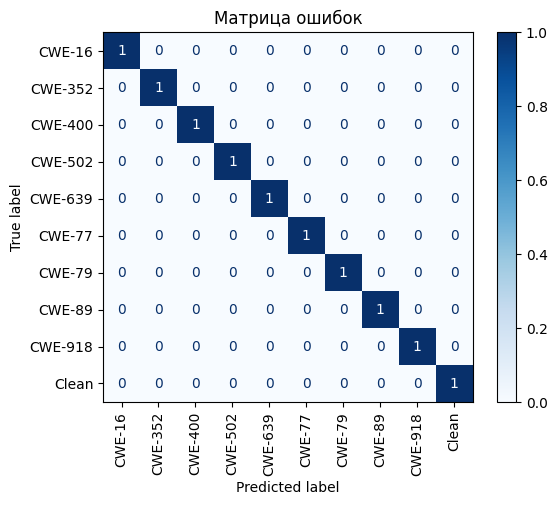

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Построение матрицы ошибок
cm = confusion_matrix(all_labels, all_predictions, normalize="true")
labels = unique_labels  # Названия классов

# Отображение
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Матрица ошибок")
plt.show()

Вычисляем F1-Score для каждого класса:

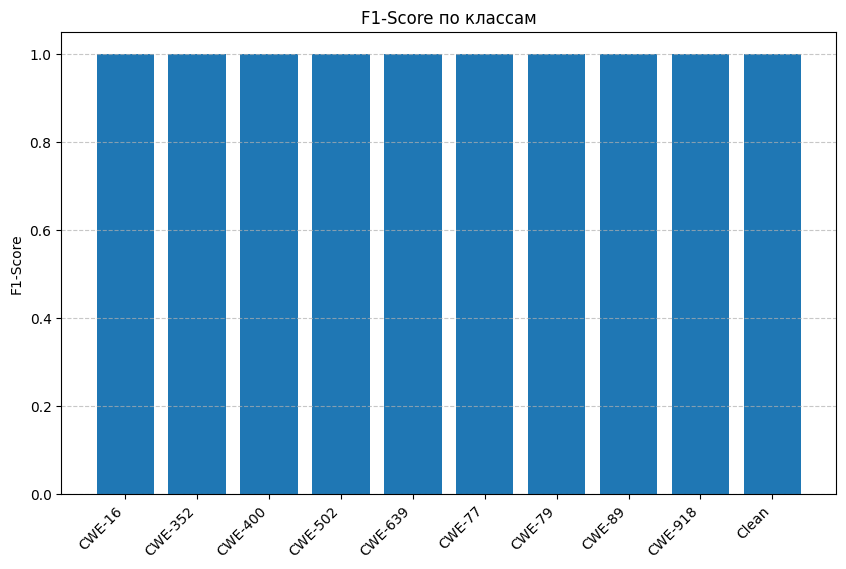

In [21]:
_, _, f1_per_class, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)

plt.figure(figsize=(10, 6))
plt.bar(labels, f1_per_class)
plt.title("F1-Score по классам")
plt.ylabel("F1-Score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Публикация модели на Hugging Face

Авторизация в Hugging Face Hub:

In [23]:
from huggingface_hub import notebook_login

notebook_login()

Сохраняем конфигурацию и веса обученной модели:

In [24]:
import os

# Создание директории, если её нет
os.makedirs("my_model", exist_ok=True)

# Сохранение весов модели
torch.save(model.state_dict(), "my_model/pytorch_model.bin")

# Сохранение конфигурации
config = {
    "num_classes": len(label2id),  # Число классов
    "bert_model_name": "bert-base-uncased",  # Используемая основная модель
}
with open("my_model/config.json", "w") as f:
    import json
    json.dump(config, f)

Сохраняем токенизатор:

In [25]:
tokenizer.save_pretrained("my_model")

('my_model/tokenizer_config.json',
 'my_model/special_tokens_map.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json')

Выгружаем обученную модель и токенизатор на Hugging Face Hub:

In [26]:
from huggingface_hub import HfApi

api = HfApi()

# Загрузка весов модели
api.upload_file(
    path_or_fileobj="my_model/pytorch_model.bin",
    path_in_repo="pytorch_model.bin",
    repo_id="l1ghth4t/immunity"
)

# Загрузка конфигурации
api.upload_file(
    path_or_fileobj="my_model/config.json",
    path_in_repo="config.json",
    repo_id="l1ghth4t/immunity"
)

# Загрузка токенизатора
api.upload_folder(
    folder_path="my_model",
    repo_id="l1ghth4t/immunity"
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/l1ghth4t/immunity/commit/bdc2633687412805b0e8cbb2df77d7518994b6cf', commit_message='Upload folder using huggingface_hub', commit_description='', oid='bdc2633687412805b0e8cbb2df77d7518994b6cf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/l1ghth4t/immunity', endpoint='https://huggingface.co', repo_type='model', repo_id='l1ghth4t/immunity'), pr_revision=None, pr_num=None)